# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

#work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

#os.chdir(work_dir)

from utils.plot import cov, compare_vars, plot_varchanges
from utils.plot import compare_KLs, plot_KLs
#import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE_C, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

from utils.simulation_wrapper import event_seed, set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(25, small_steps=True)


In [4]:
window_len = 30
prior_min = [0, 0, 0, 0, 0, 0, 0, 0, 17.3,    # prox1 weights
            0, 0, 0, 0, 0, 0, 51.980,            # distal weights
            0, 0, 0, 0, 0, 0, 0, 0, 112.13]       # prox2 weights



prior_max = [0.927, 1.0, 0.160, 1.0,  2.093, 1.0, 0.0519, 1.0, 35.9,
            0.0394, 0.117, 0.000042, 0.025902, 0.854, 0.480, 75.08, 
            0.000018, 1.0, 8.633, 1.0, 0.05375, 1.0, 4.104,  1.0, 162.110]

true_params = torch.tensor([[0.277, 0.3739, 0.0399, 0.0, 0.6244, 0.3739, 0.034, 0.0, 18.977, 
                0.011467, 0.06337, 0.000012, 0.013407, 0.466095, 0.0767, 63.08, 
                0.000005, 0.116706, 4.6729, 0.016733, 0.011468, 0.061556, 2.33, 0.0679, 120.86]])

prior = utils.torchutils.BoxUniform(low=prior_min, high=prior_max)

#number_simulations = 10
density_estimator = 'nsf'


In [5]:

#assert (prior.event_shape==torch.Size([25]))
from utils import inference

In [6]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/'

os.chdir(work_dir)



import os

print(os.getcwd())

#os.chdir('/home/kathi/Documents/Master_thesis/results_cluster/')



#print(os.getcwd())

#os.chdir('/home/kathi/Documents/Master_thesis/results_cluster')

## loading simulations from previously saved computations
#file = 'ERP_sequential_3params/step3'
#file = 'ERP_save_sim_nsf_num_params3'
#file = 'eval_features'
#file = '10000_multi_round_num_params_25newparams'

file = '10000_sims_25_fake_obs_3steps_time'

os.chdir('..')
print(os.getcwd())

os.chdir('results')

print(os.getcwd())
  

thetas = torch.load('{}/thetas.pt'.format(file))

#posterior = torch.load('{}/posterior.pt'.format(file))
x_without = torch.load('{}/obs_without.pt'.format(file))

x = calculate_summary_stats_temporal(x_without)


#true_params = torch.tensor([[0.0274, 19.01, 0.1369, 61.89, 0.1435, 120.86]])
#true_params = torch.tensor([[  18.9700, 63.5300, 137.1200]])
#true_params = torch.load('results/{}/true_params.pt'.format(file))
#true_params = torch.tensor([[0.277, 0.0399, 0.3739, 0.034, 18.977, 0.0115, 0.000012, 0.466, 0.06337, 0.0134, 0.0766, 63.08, 0.000005, 4.6729, 0.0115, 0.3308, 120.86]])

obs_real = torch.load('{}/obs_real.pt'.format(file))

/home/ubuntu/sbi_for_eeg_data
/home/ubuntu
/home/ubuntu/results


## Inference step:

In [7]:
density_estimator = 'nsf'



#inf = SNPE(prior=prior, density_estimator = density_estimator)

inf = SNPE_C(prior, density_estimator="nsf")

inf = inf.append_simulations(thetas, x)

density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)


#true_params = torch.tensor([[26.61, 63.53,  137.12]])

Neural network successfully converged after 58 epochs.


## Simulation under 'true parameters'

In [8]:
#obs_real = inference.run_only_sim(true_params, simulation_wrapper = sim_wrapper)
obs_real = torch.load('{}/obs_real.pt'.format(file))

In [12]:
obs_real_stat = calculate_summary_stats_temporal(obs_real)

samples = posterior.sample((100000,), x=obs_real_stat)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [11]:
parameter_names = ["prox1_ampa_l2_bas","prox1_nmda_l2_bas","prox1_ampa_l2_pyr", "prox1_nmda_l2_pyr", "prox1_ampa_l5_bas", "prox1_nmda_l5_bas", "prox1_ampa_l5_pyr", "prox1_nmda_l5_pyr",
"t_prox1",
"dist_ampa_l2_bas", "dist_nmda_l2_bas", "dist_ampa_l2_pyr", "dist_nmda_l2_pyr", "dist_ampa_l5_pyr","dist_nmda_l5_pyr",
"t_dist", 
"prox2_ampa_l2_bas","prox2_nmda_l2_bas","prox2_ampa_l2_pyr", "prox2_nmda_l2_pyr", "prox2_ampa_l5_bas", "prox2_nmda_l5_bas", "prox2_ampa_l5_pyr", "prox2_nmda_l5_pyr",
"t_prox2"]

In [12]:
##better limits:

list_min = torch.min(samples, 0)[0]
list_max = torch.max(samples, 0)[0]

print(list_min)

print(list_max)

diff = torch.abs(list_max - list_min) * 0.5

print(diff)

list_min = list(list_min - diff)
list_max = list(list_max + diff)

limits = [list(tup) for tup in zip(list_min, list_max)]

tensor([3.6228e-07, 2.6209e-05, 3.3565e-06, 1.6179e-07, 1.8739e-04, 6.7044e-05,
        6.3319e-05, 1.3243e-07, 1.7320e+01, 8.3535e-06, 2.1663e-04, 2.1895e-10,
        5.4898e-04, 1.5912e-04, 8.1785e-04, 5.2001e+01, 0.0000e+00, 3.2360e-05,
        2.7508e-04, 1.8956e-06, 2.7872e-06, 4.1372e-06, 1.0091e-03, 4.2167e-06,
        1.1213e+02])
tensor([9.1732e-01, 9.9998e-01, 1.5825e-01, 1.3774e-01, 2.0915e+00, 9.9924e-01,
        5.1878e-02, 1.5241e-01, 2.7122e+01, 3.9400e-02, 1.1700e-01, 4.1999e-05,
        2.5902e-02, 8.5400e-01, 3.2682e-01, 7.1003e+01, 1.7999e-05, 1.0000e+00,
        8.6327e+00, 9.9998e-01, 5.3748e-02, 9.9998e-01, 4.1015e+00, 9.5729e-01,
        1.6083e+02])
tensor([4.5866e-01, 4.9998e-01, 7.9122e-02, 6.8868e-02, 1.0456e+00, 4.9959e-01,
        2.5907e-02, 7.6203e-02, 4.9012e+00, 1.9696e-02, 5.8391e-02, 2.1000e-05,
        1.2676e-02, 4.2692e-01, 1.6300e-01, 9.5008e+00, 8.9993e-06, 4.9998e-01,
        4.3162e+00, 4.9999e-01, 2.6873e-02, 4.9999e-01, 2.0503e+00, 4.7864e-01

<Figure size 432x288 with 0 Axes>

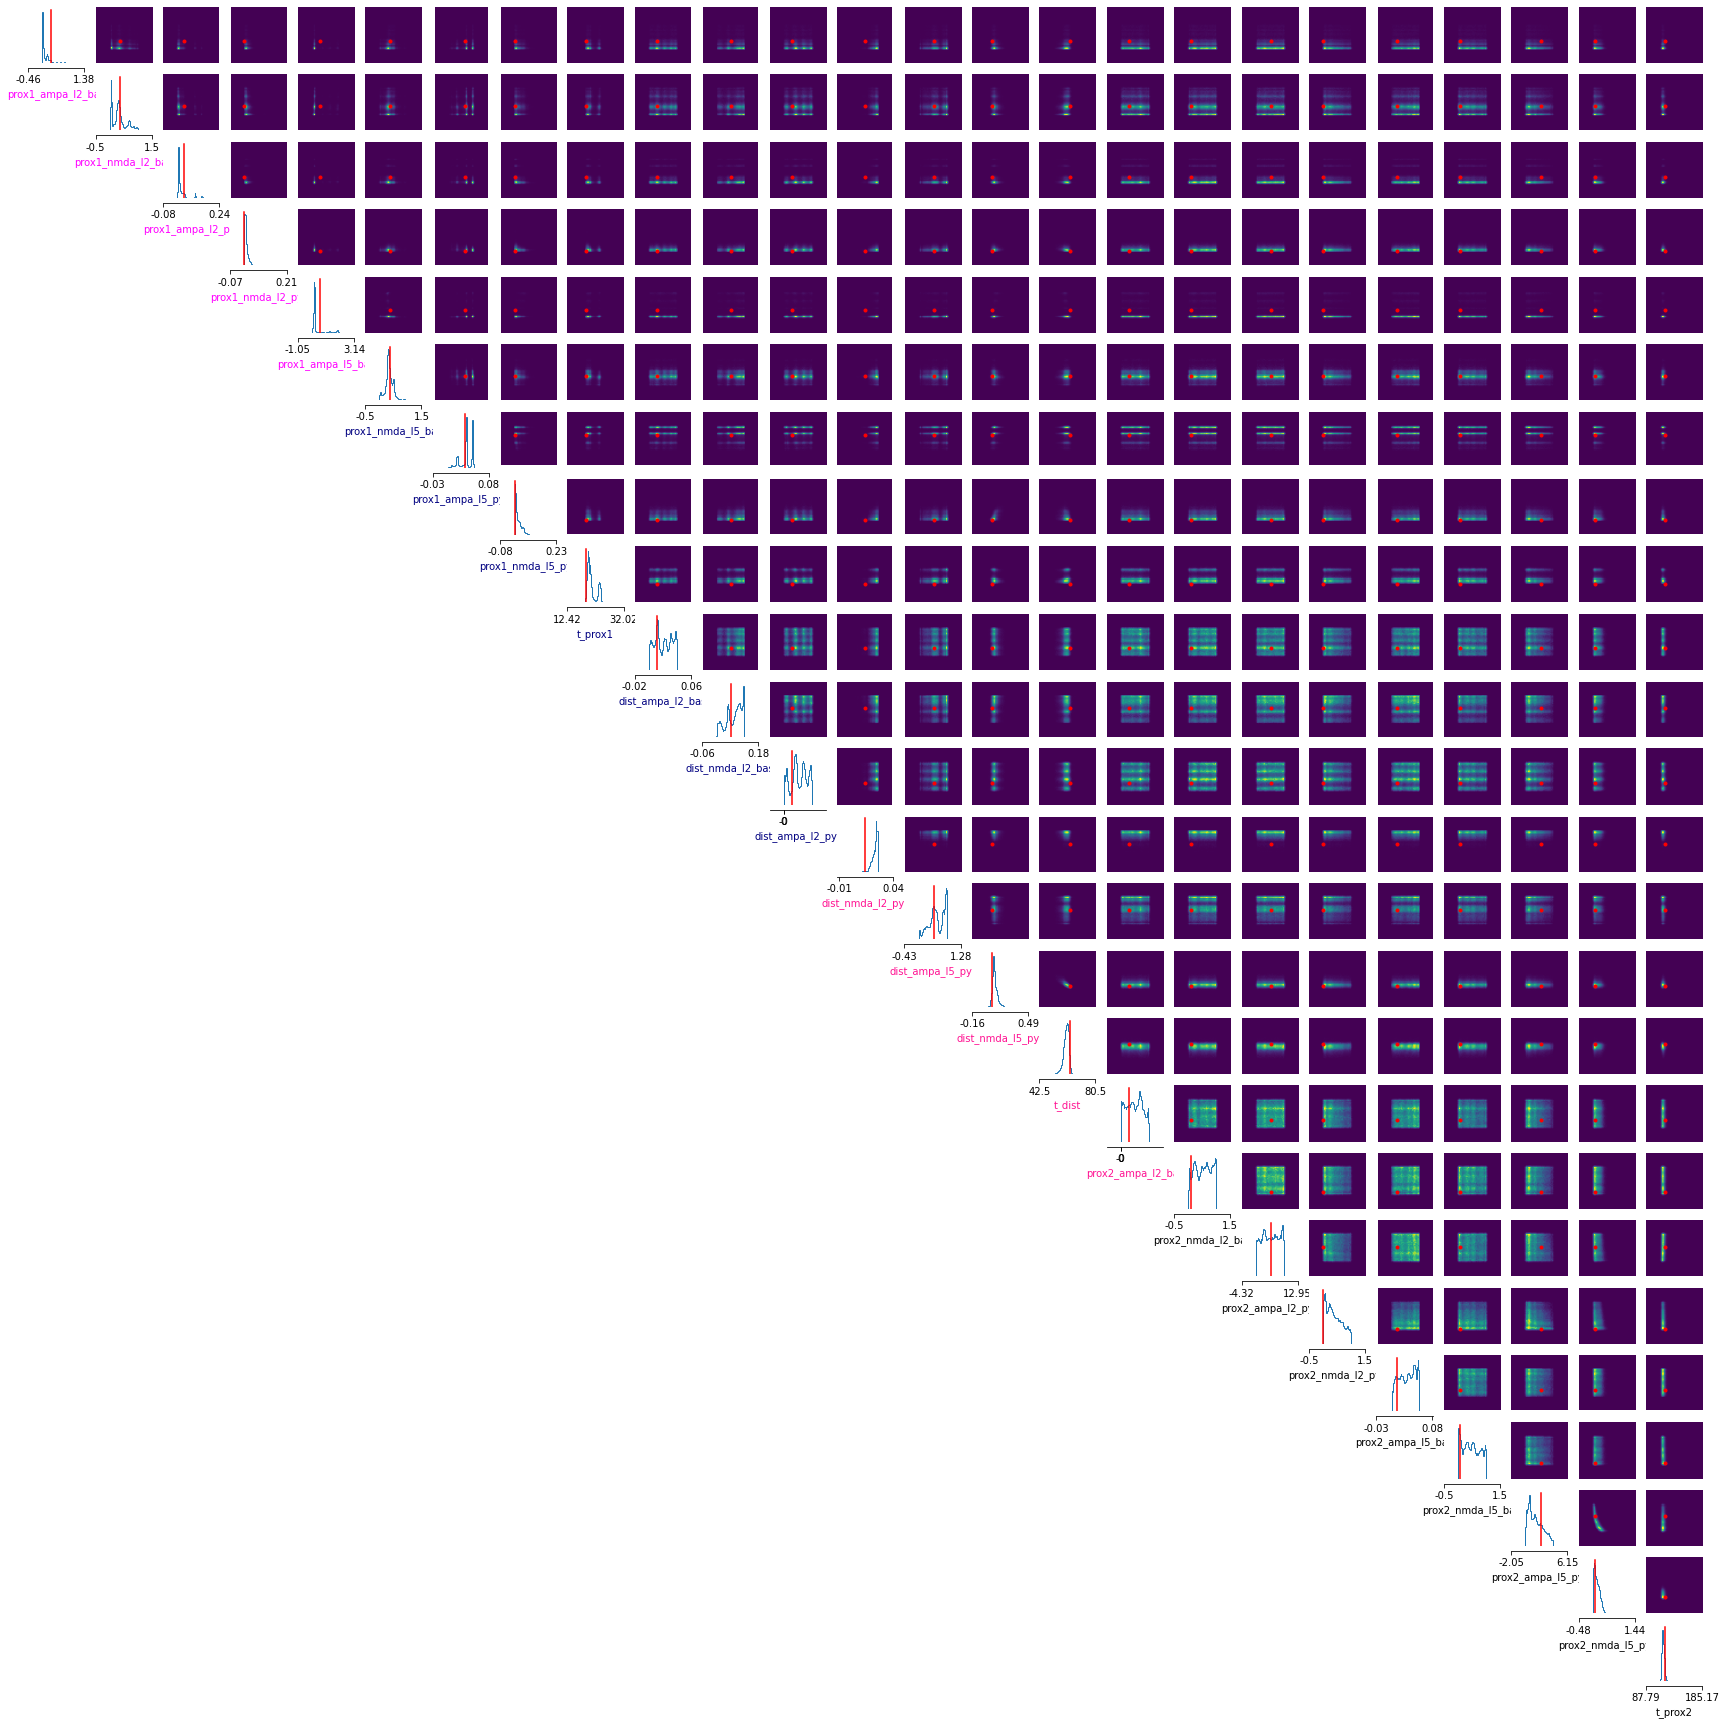

In [13]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]


plt.set_cmap('viridis')

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=np.round(limits,2),
    figsize=(30, 30),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=parameter_names,
)

for i in range(5):
    axes[i][i].xaxis.label.set_color('magenta')
for i in range(5, 12):
    axes[i][i].xaxis.label.set_color('navy')
for i in range(12, 17):
    axes[i][i].xaxis.label.set_color('deeppink')

In [14]:
posterior.set_default_x(obs_real_stat)
condition = posterior.sample((1,))

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

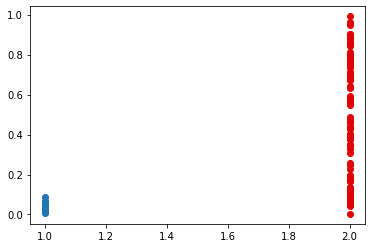

In [68]:

for i in range(100):

    plt.scatter(1, samples[i][7])
    plt.scatter(2, samples_prior[i][7])

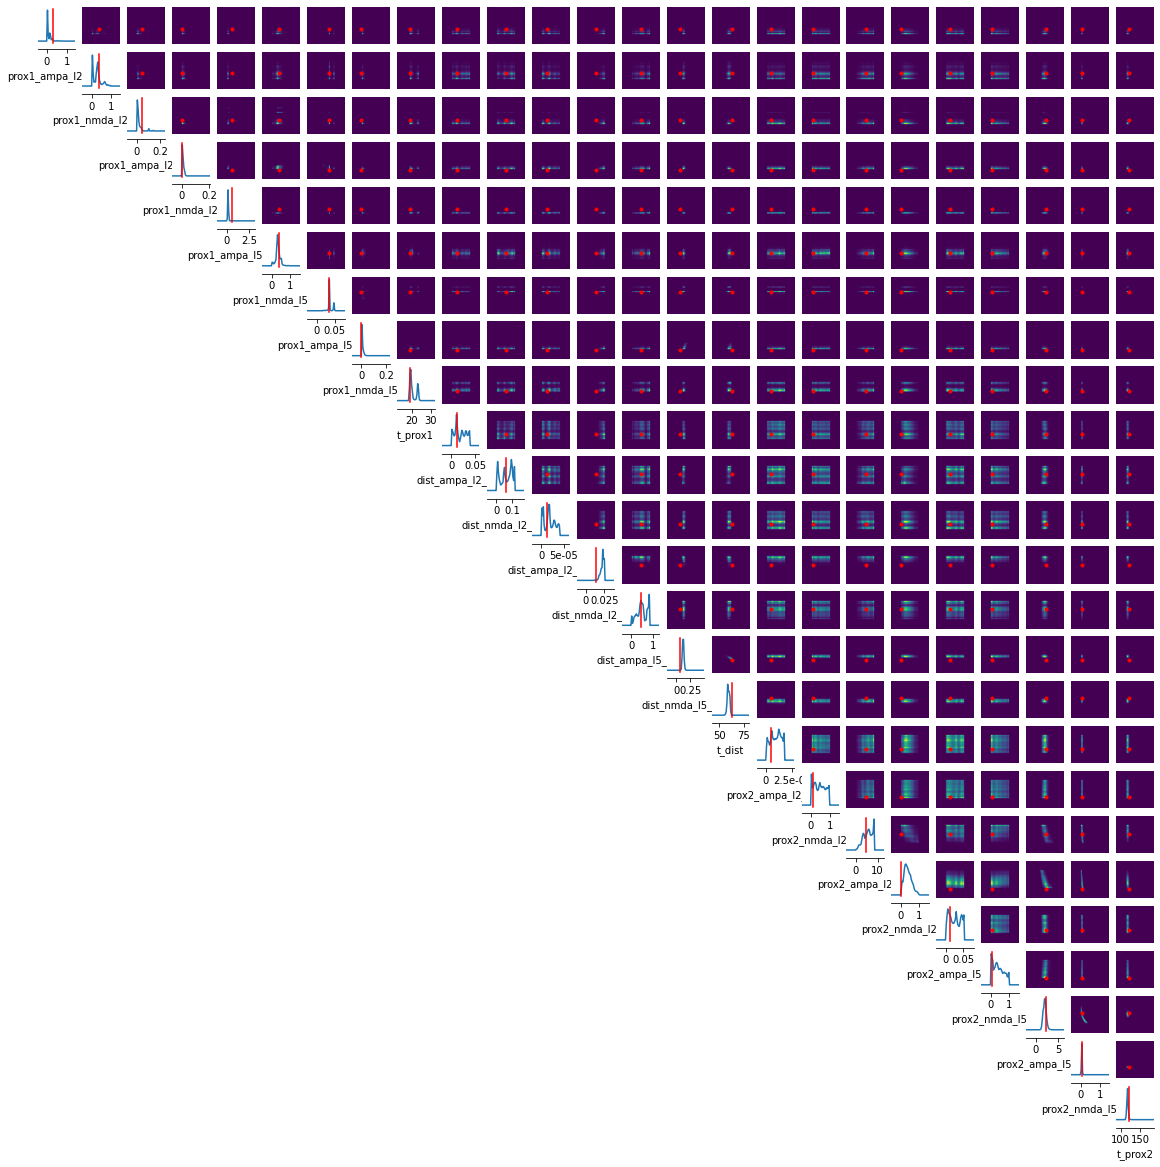

In [15]:
_ = analysis.conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=limits,
    figsize=(20, 20),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=parameter_names,
    #color_map = ['Blues', 'Reds'],
    #alpha1 = 0.8,
    #alpha2 = 0.4
 
)


In [16]:
samples = posterior.sample((100,), x=obs_real_stat)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
s_x = inference.run_only_sim(samples, simulation_wrapper=sim_wrapper, num_workers=8)

early stop 200.0early stop 200.0

param size early stop param size 
25 25early stop  [0.20786963403224945, 0.704474925994873, 0.006151028908789158, 0.002444138750433922, 0.09783291816711426, 0.2814788818359375, 0.04841083660721779, 0.01591433212161064, 19.422025680541992, 0.004191861022263765, 0.043937504291534424, 2.3742622943245806e-06, 0.024346452206373215, 0.8414924740791321, 0.08549538254737854, 62.50917434692383, 1.1141056347696576e-05, 0.6626543998718262, 0.03499696031212807, 0.8940036296844482, 0.0177449993789196, 0.1891465038061142, 2.547384738922119, 0.009832587093114853, 115.36315155029297]200.0200.0
early stop

 param size 200.0
param size  early stop
25param size 
  25 [0.046912793070077896, 0.57010817527771, 0.045765820890665054, 0.000160842522745952, 1.0708476305007935, 0.381526380777359, 0.04912767931818962, 0.024503152817487717, 21.3231143951416, 0.02893730252981186, 0.042845215648412704, 2.5001045287353918e-05, 0.02172866463661194, 0.44862645864486694, 0.0852429866790

[0.14684703946113586, 0.031305428594350815, 0.04047786816954613, 0.020981626585125923, 0.14371562004089355, 0.5435807108879089, 0.03522808849811554, 0.0013688182225450873, 19.42275619506836, 0.0349770113825798, 0.11594100296497345, 9.713613508210983e-06, 0.02410370483994484, 0.8326454758644104, 0.09511305391788483, 59.67060852050781, 1.3877037417842075e-05, 0.678636908531189, 7.868277549743652, 0.26873326301574707, 0.015800783410668373, 0.07013186067342758, 0.736738383769989, 0.1276528388261795, 119.46664428710938]
set network params: [0.14684703946113586, 0.031305428594350815, 0.04047786816954613, 0.020981626585125923, 0.14371562004089355, 0.5435807108879089, 0.03522808849811554, 0.0013688182225450873, 19.42275619506836, 0.0349770113825798, 0.11594100296497345, 9.713613508210983e-06, 0.02410370483994484, 0.8326454758644104, 0.09511305391788483, 59.67060852050781, 1.3877037417842075e-05, 0.678636908531189, 7.868277549743652, 0.26873326301574707, 0.015800783410668373, 0.0701318606734275

early stop 200.0
param size  25
[0.15963123738765717, 0.056038275361061096, 0.01194050069898367, 0.0014344272203743458, 0.12302658706903458, 0.12662915885448456, 0.03692182898521423, 0.04807283356785774, 22.998157501220703, 0.027097277343273163, 0.05441296100616455, 1.0412691153760534e-05, 0.023851217702031136, 0.790012776851654, 0.09970863163471222, 61.15416717529297, 5.540218808164354e-06, 0.26335716247558594, 2.8202407360076904, 0.08989576250314713, 0.023572372272610664, 0.7272294759750366, 2.2934932708740234, 0.08104561269283295, 115.9560775756836]
set network params: [0.15963123738765717, 0.056038275361061096, 0.01194050069898367, 0.0014344272203743458, 0.12302658706903458, 0.12662915885448456, 0.03692182898521423, 0.04807283356785774, 22.998157501220703, 0.027097277343273163, 0.05441296100616455, 1.0412691153760534e-05, 0.023851217702031136, 0.790012776851654, 0.09970863163471222, 61.15416717529297, 5.540218808164354e-06, 0.26335716247558594, 2.8202407360076904, 0.089895762503147

set network params: [0.23062726855278015, 0.06635330617427826, 0.008117146790027618, 0.000958975579123944, 0.1452254354953766, 0.28361576795578003, 0.04952748864889145, 0.003170004114508629, 23.729021072387695, 0.03795503452420235, 0.10261986404657364, 1.268334744963795e-05, 0.025399090722203255, 0.5563300848007202, 0.06107012927532196, 62.803775787353516, 1.1987400284851901e-05, 0.5819910168647766, 1.382827639579773, 0.06730414181947708, 0.03509518504142761, 0.8082839846611023, 0.819366455078125, 0.30351269245147705, 113.59569549560547]
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  20 tasks      | elapsed:  4.9min
Simulation time: 40.0 ms...
Building the NEURON model
Simulation time: 180.0 ms...
Simulation time: 170.0 ms...
Simulation time: 20.0 ms...
Simulation time: 150.0 ms...
Simulation time: 190.0 ms...
Simulation time: 50.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 30.0

set network params: [0.14664719998836517, 0.3246369957923889, 0.029739616438746452, 0.0007209135801531374, 0.5310750007629395, 0.35498136281967163, 0.04915817081928253, 0.012380678206682205, 20.138103485107422, 0.022426338866353035, 0.06390358507633209, 2.5350098439957947e-05, 0.025544438511133194, 0.7473194599151611, 0.10177779197692871, 60.596927642822266, 4.876482307736296e-06, 0.6813173294067383, 5.63855504989624, 0.9471564292907715, 0.007456016261130571, 0.23298139870166779, 0.1755775809288025, 0.24058496952056885, 118.98797607421875]
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  29 tasks      | elapsed:  6.7min
Simulation time: 10.0 ms...
early stop 200.0
param size  25
[0.13817673921585083, 0.055468712002038956, 0.011657541617751122, 0.025004345923662186, 0.13479042053222656, 0.36652466654777527, 0.01985655166208744, 0.005634342320263386, 19.469966888427734, 0.03126576915383339, 0.06437914818525314, 3.3562889711902244e-07, 0.02177177183330059, 0.7256879806518555, 0.102

Simulation time: 180.0 ms...
Simulation time: 160.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Building the NEURON model
Simulation time: 20.0 ms...
Simulation time: 60.0 ms...
Simulation time: 100.0 ms...
Simulation time: 190.0 ms...
Simulation time: 170.0 ms...
Simulation time: 10.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 110.0 ms...
early stop 200.0
param size  25
[0.013845391571521759, 0.2981692850589752, 0.004896174650639296, 0.010218126699328423, 0.21973294019699097, 0.22121237218379974, 0.0473453551530838, 0.024106254801154137, 19.722856521606445, 0.03651095926761627, 0.09148795157670975, 2.222616421931889e-05, 0.025006718933582306, 0.52350914478302, 0.09463663399219513, 61.35430145263672, 4.1092466744885314e-06, 0.6056410074234009, 7.335049152374268, 0.49540621042251587, 0.05159371346235275, 0.9065859317779541, 1.9566011428833008, 0.05110856145620346, 116.03944396972656]
set network params: [0.013845391571521

set network params: [0.21223798394203186, 0.18566685914993286, 0.012659002095460892, 0.010334080085158348, 1.1151291131973267, 0.29451146721839905, 0.04817230626940727, 0.04579620808362961, 19.099201202392578, 0.017115680500864983, 0.037207067012786865, 2.441316428303253e-05, 0.019946232438087463, 0.708415150642395, 0.16364966332912445, 57.7992057800293, 3.1566271445626626e-06, 0.9460107684135437, 1.7707313299179077, 0.1543320119380951, 0.04279937967658043, 0.3739761710166931, 1.810668706893921, 0.15637722611427307, 115.5985107421875]
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  47 tasks      | elapsed: 10.3min
Simulation time: 190.0 ms...
Simulation time: 40.0 ms...
Building the NEURON model
Simulation time: 70.0 ms...
Simulation time: 10.0 ms...
Simulation time: 130.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
early stop 200.0
param size  25
[0.05518374219536781, 0.06693470478057861, 0.01087118498980999, 0.03455023840069771, 0.18213990330696106, 0.230080

set network params: [0.2732522189617157, 0.8618137240409851, 0.02384968288242817, 0.00016256740491371602, 0.1990671157836914, 0.4284141957759857, 0.04653310403227806, 0.013987382873892784, 20.503406524658203, 0.03366352990269661, 0.08936923742294312, 3.884902616846375e-05, 0.024695707485079765, 0.41029489040374756, 0.08508262783288956, 62.304988861083984, 1.674019767960999e-05, 0.6798850893974304, 1.236190915107727, 0.19948826730251312, 0.020997429266572, 0.6239850521087646, 0.07469117641448975, 0.3994465470314026, 120.02737426757812]
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 12.1min
Building the NEURON model
Simulation time: 40.0 ms...
Building the NEURON model
Simulation time: 30.0 ms...
Simulation time: 60.0 ms...
Simulation time: 90.0 ms...
Simulation time: 10.0 ms...
Simulation time: 140.0 ms...
Simulation time: 50.0 ms...
Simulation time: 40.0 ms...
Simulation time: 70.0 ms...
Simulation time: 100.0 ms...
Simulation time: 20.0 ms...
[Done]
r

running trial 1 on 1 cores[Done]

running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 0.03 ms...
Simulation time: 190.0 ms...
Simulation time: 50.0 ms...
Simulation time: 90.0 ms...
Simulation time: 80.0 ms...
Simulation time: 110.0 ms...
Simulation time: 100.0 ms...
Simulation time: 10.0 ms...
Simulation time: 10.0 ms...
early stop 200.0
param size  25
[0.05092544108629227, 0.25246843695640564, 0.002205731812864542, 0.021429283544421196, 0.10829168558120728, 0.21004189550876617, 0.03657786548137665, 0.002889461349695921, 19.373350143432617, 0.0232273917645216, 0.010725497268140316, 9.233383025275543e-06, 0.02408384159207344, 0.6509379744529724, 0.10075897723436356, 59.793453216552734, 5.295579285302665e-06, 0.4902132451534271, 4.628083229064941, 0.2821331322193146, 0.05293751135468483, 0.8095841407775879, 0.8610458374023438, 0.08910655975341797, 116.89762878417969]
set network params: [0.05092544108629227, 0.25246843695640564, 0.002205731812864542, 0.02142928354442

Simulation time: 70.0 ms...
Simulation time: 50.0 ms...
Simulation time: 20.0 ms...
Simulation time: 120.0 ms...
Simulation time: 100.0 ms...
Simulation time: 100.0 ms...
Simulation time: 30.0 ms...
Simulation time: 80.0 ms...
Simulation time: 60.0 ms...
Simulation time: 130.0 ms...
Simulation time: 110.0 ms...
Simulation time: 30.0 ms...
Simulation time: 110.0 ms...
Simulation time: 40.0 ms...
Simulation time: 70.0 ms...
Simulation time: 90.0 ms...
[Done]
Simulation time: 140.0 ms...running trial 1 on 1 cores

Simulation time: 0.03 ms...
Simulation time: 120.0 ms...
Simulation time: 40.0 ms...
Simulation time: 120.0 ms...
Simulation time: 50.0 ms...
Simulation time: 80.0 ms...
Simulation time: 150.0 ms...
Simulation time: 130.0 ms...
Simulation time: 100.0 ms...
Simulation time: 130.0 ms...
Simulation time: 50.0 ms...
Simulation time: 10.0 ms...
Simulation time: 90.0 ms...
Simulation time: 60.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 110.0 ms..

Simulation time: 130.0 ms...
Simulation time: 80.0 ms...
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...
Simulation time: 180.0 ms...
Simulation time: 40.0 ms...
early stop 200.0
param size  25
[0.033096011728048325, 0.04131072387099266, 0.00978629756718874, 0.0042244913056492805, 0.19393832981586456, 0.024117806926369667, 0.044758141040802, 0.03446696698665619, 20.191526412963867, 0.013125160709023476, 0.11626934260129929, 1.5299696315196343e-05, 0.02552780695259571, 0.48211124539375305, 0.11605150997638702, 59.15445327758789, 6.711217110932921e-07, 0.7476134896278381, 3.8815155029296875, 0.6605045199394226, 0.039802730083465576, 0.06741024553775787, 1.52381432056427, 0.0752330794930458, 115.75659942626953]
set network params: [0.033096011728048325, 0.04131072387099266, 0.00978629756718874, 0.0042244913056492805, 0.19393832981586456, 0.024117806926369667, 0.044758141040802, 0.03446696698665619, 20.191526412963867, 0.013125160709023476, 0.11626934260129929, 1.5299696315196343

[0.030116451904177666, 0.04214048385620117, 0.012490527704358101, 0.006640058476477861, 0.16154205799102783, 0.24619095027446747, 0.03529790788888931, 0.0031101854983717203, 19.346765518188477, 0.01096885185688734, 0.11690083146095276, 1.7736676454660483e-05, 0.02542157471179962, 0.2679497003555298, 0.09489700943231583, 59.527591705322266, 1.3846402907802258e-05, 0.4648664891719818, 8.140257835388184, 0.03488561883568764, 0.04269231855869293, 0.8352982401847839, 1.8713808059692383, 0.10084319114685059, 112.6281967163086]
set network params: [0.030116451904177666, 0.04214048385620117, 0.012490527704358101, 0.006640058476477861, 0.16154205799102783, 0.24619095027446747, 0.03529790788888931, 0.0031101854983717203, 19.346765518188477, 0.01096885185688734, 0.11690083146095276, 1.7736676454660483e-05, 0.02542157471179962, 0.2679497003555298, 0.09489700943231583, 59.527591705322266, 1.3846402907802258e-05, 0.4648664891719818, 8.140257835388184, 0.03488561883568764, 0.04269231855869293, 0.8352

In [ ]:
### sample from prior now
num_samples = 100
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)
    

In [ ]:
samples_prior[:][0].shape

In [ ]:
    
s_x_prior = inference.run_only_sim(samples_prior, sim_wrapper, num_workers=8)

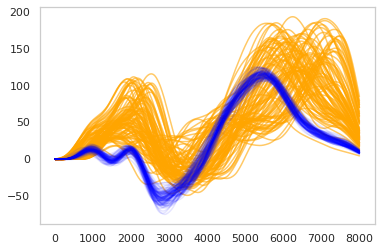

In [47]:
for i in range(100):
    plt.plot(s_x_prior[i], color='orange', alpha=0.6)
    
for i in range(100):
    plt.plot(s_x[i], color='blue', alpha=0.1)

In [22]:
s_x_torch = torch.stack(([s_x[i] for i in range(len(s_x))]))
s_x_prior_torch = torch.stack(([s_x_prior[i] for i in range(len(s_x_prior))]))


mean = torch.mean(s_x_torch, 0)
std = torch.std(s_x_torch, 0)

mean_prior = torch.mean(s_x_prior_torch, 0)
std_prior = torch.std(s_x_prior_torch, 0)

lower = mean - 1.96 * std


upper = mean + 1.96 * std


lower_prior = mean_prior - 1.96 * std_prior


upper_prior = mean_prior + 1.96 * std_prior



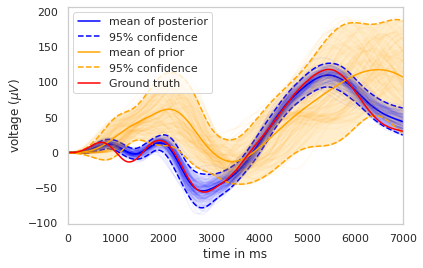

In [23]:
import seaborn as sns

sns.set() 

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_style('ticks')

fig1, ax = plt.subplots(1, 1)
#ax.set_title("Comparing signal")

    
plt.plot(mean, color ='blue', label='mean of posterior')

for s in s_x:
    plt.plot(s, alpha=0.05, color='blue')
    #plt.ylim(-30,30)
    plt.xlim(0, 7000)

plt.plot(lower, color='blue', linestyle='dashed', label='95% confidence')
plt.plot(upper, color='blue', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower, y2=upper, color='blue', alpha=0.1)
plt.xlim(0, 7000)


plt.plot(mean_prior, color ='orange', label='mean of prior')


for x_w in s_x_prior:
    plt.plot(x_w, alpha=0.05, color='orange')

plt.plot(lower_prior, color='orange', linestyle='dashed', label='95% confidence')
plt.plot(upper_prior, color='orange', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower_prior, y2=upper_prior, color='orange', alpha=0.2)
plt.xlim(0, 7000)

plt.xlabel('time in ms')
#plt.ylabel('voltage ()')

fig1.gca().set_ylabel(r'voltage ($\mu V$)')
    
plt.plot(obs_real[0], label='Ground truth', color='red')



plt.legend()

## Correlation matrices

In [24]:
corr_matrix_marginal = np.corrcoef(posterior_samples.T)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

NameError: name 'posterior_samples' is not defined

In [ ]:
condition = posterior.sample((1,))

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2., 2.]]*3),
    figsize=(5,5)
)

## Evaluation of features

In [28]:
import matplotlib.cm as cm
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch import Tensor
from typing import Tuple, List, Optional, Dict
from matplotlib.pyplot import Axes
from matplotlib.figure import Figure
from matplotlib.colors import LogNorm


In [68]:
t = obs_real_stat

t

tensor([[ 1.9490e+03,  2.7060e+03,  5.9300e+03,  2.1558e+01, -4.0164e+01,
          1.9919e+02,  1.5108e+01,  6.7586e+01,  1.9520e+02,  3.2594e+01,
          7.0213e+03,  1.2655e+01,  2.1028e+04, -1.1747e+04,  1.6931e+04,
         -2.2304e+04,  3.4816e+05,  0.0000e+00,  4.7747e+01,  7.9176e+00]],
       dtype=torch.float64)

In [74]:
# t.shape

t1 = torch.cat((t[:,:1], t[:,1+1:]), axis = 1)
print(t1)
t1.shape

tensor([[ 1.9490e+03,  5.9300e+03,  2.1558e+01, -4.0164e+01,  1.9919e+02,
          1.5108e+01,  6.7586e+01,  1.9520e+02,  3.2594e+01,  7.0213e+03,
          1.2655e+01,  2.1028e+04, -1.1747e+04,  1.6931e+04, -2.2304e+04,
          3.4816e+05,  0.0000e+00,  4.7747e+01,  7.9176e+00]],
       dtype=torch.float64)


torch.Size([1, 19])

In [54]:
posterior.set_default_x(obs_real_stat)

DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=BoxUniform(Uniform(low: torch.Size([17]), high: torch.Size([17])), 1),
               x_shape=torch.Size([1, 20]))
               

In [55]:
thetas = posterior.sample((10000,))
thetas.shape

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 17])

In [79]:

for i in range(20):
    x = calculate_summary_stats_temporal(x_without)
    #leaving one summary statistic out
    x_c = torch.cat((x[:,:i], x[:,i+1:]), axis = 1)
    print(x_c.shape)
    print('t shape', t.shape)
    print(torch.cat((t[:i], t[i+1:]), axis = 0).shape)
    inf = SNPE(prior=prior, density_estimator = 'nsf')
    inf = inf.append_simulations(thetas, x_c)
    density_estimator = inf.train()
    posterior1 = inf.build_posterior(density_estimator)
    globals()['samples_%s' % i] = posterior1.sample((num_samples,), x=torch.cat((t[:,:i], t[:,i+1:]), axis = 1))


torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

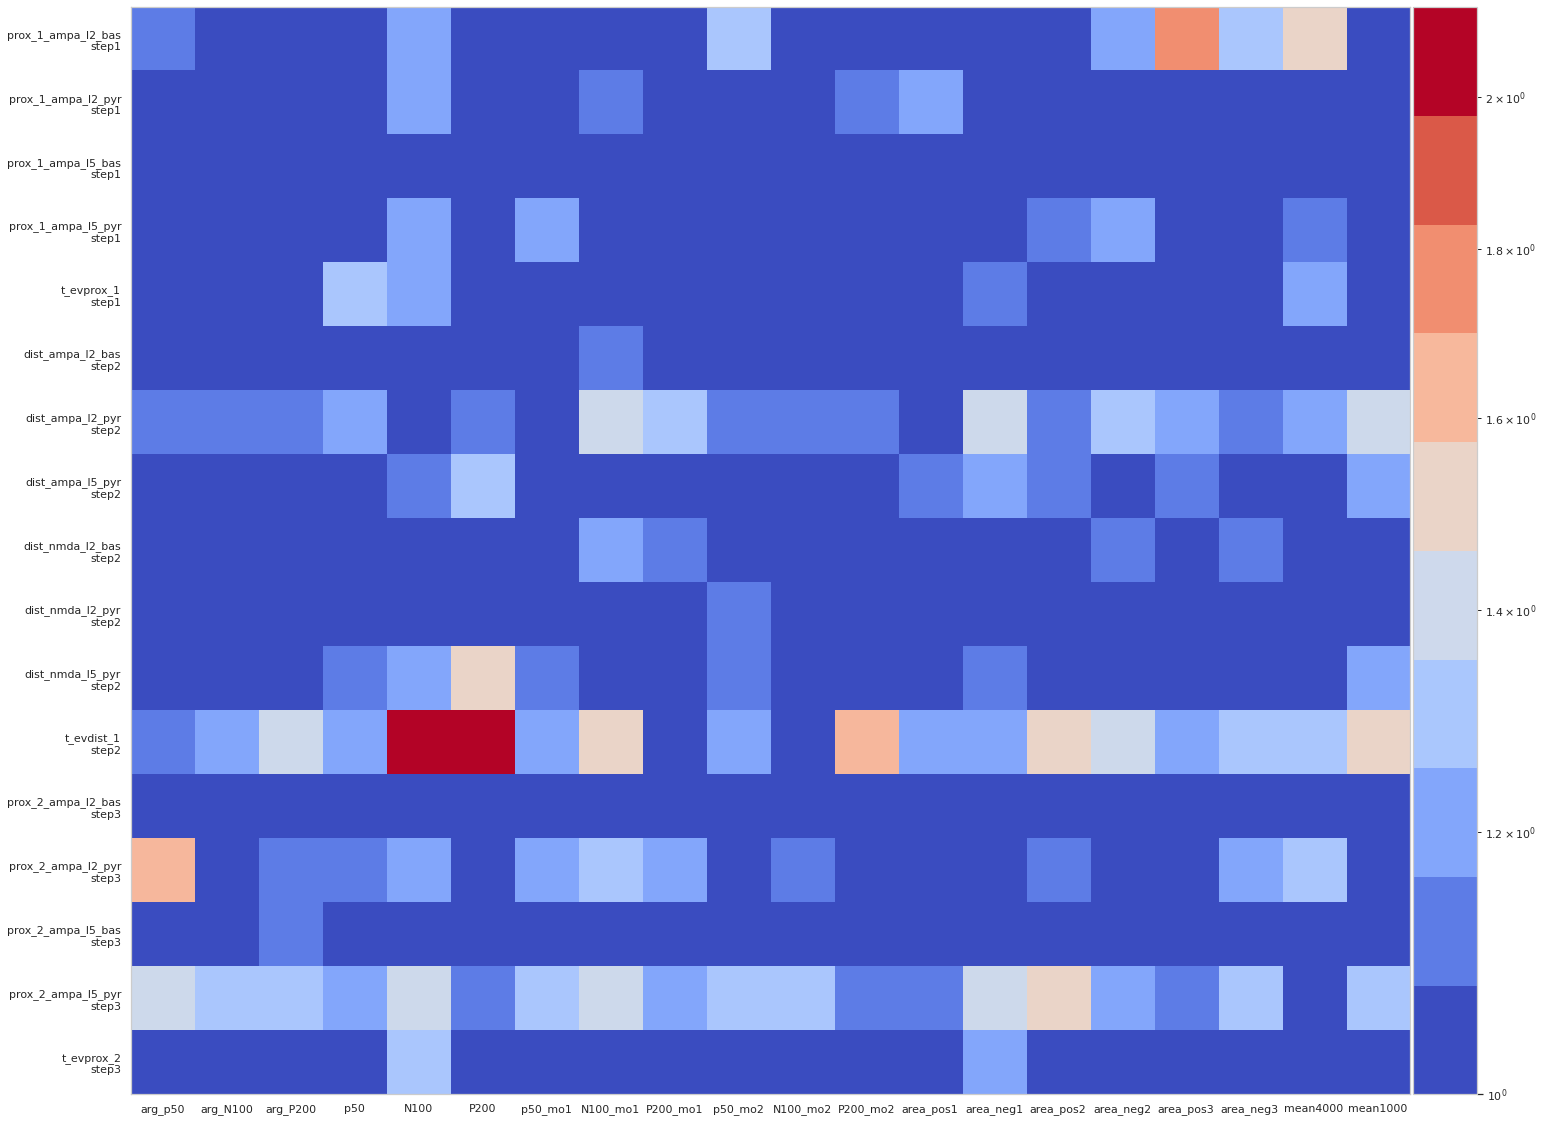

In [106]:
sum_stats_names =                 [
                    'arg_p50',
                    'arg_N100',
                    'arg_P200',
                    'p50',
                    'N100',
                    'P200',
                    'p50_mo1',
                    'N100_mo1',
                    'P200_mo1',
                    'p50_mo2',
                    'N100_mo2',
                    'P200_mo2',
                    'area_pos1',
                    'area_neg1',
                    'area_pos2',
                    'area_neg2',
                    'area_pos3',
                    'area_neg3',
                    'mean4000',
                    'mean1000'
                ]

sample_list = []
for i in range(20):
    sample_list.append(globals()['samples_%s' % i] )

    
plt.figure(figsize = (25,20))
im = plot_varchanges(sample_list, samples, xticklabels=sum_stats_names, yticklabels= parameter_names, plot_label='', batchsize=0)
plt.show(im)

In [120]:
sample_batch = []
batch_size = 5

for i in range(batch_size):

    sample_list = []
    
    for i in range(20):
        

        x = calculate_summary_stats_temporal(x_without)
        #leaving one summary statistic out
        x_c = torch.cat((x[:,:i], x[:,i+1:]), axis = 1)
        print(x_c.shape)
        print('t shape', t.shape)
        print(torch.cat((t[:i], t[i+1:]), axis = 0).shape)
        inf = SNPE(prior=prior, density_estimator = 'nsf')
        inf = inf.append_simulations(thetas, x_c)
        density_estimator = inf.train()
        posterior1 = inf.build_posterior(density_estimator)
        globals()['samples_%s' % i] = posterior1.sample((num_samples,), x=torch.cat((t[:,:i], t[:,i+1:]), axis = 1))
        
        sample_list.append(globals()['samples_%s' % i] )
        
    sample_batch.append(sample_list)

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 36 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 36 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])


KeyboardInterrupt: 

In [119]:
sample_batch

[]

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0, 0.5, 'voltage ($\\mu V$)')

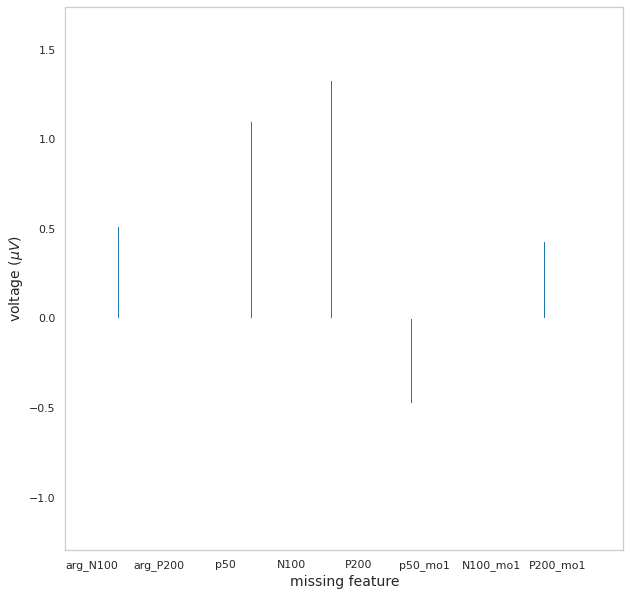

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True)


plot_KLs(sample_list,
        samples,
        idx=0,
        batchsize=0,
         kind='bar',
        agg_with='mean'
    )


axes.set_xlabel("missing feature", size=14)
axes.set_xticklabels(sum_stats_names)
ax.tick_params(axis="both", which="major", labelsize=12)
ylabel = ax.get_ylabel()
axes.set_ylabel(ylabel, size=14)


In [16]:
#s_x_prior_stat = calculate_summary_stats_temporal(s_x_prior)
#s_x_stat = calculate_summary_stats_temporal(s_x)
posterior.set_default_x(obs_real_stat)
    
s_x_prior_stat = prior.sample((1000,))

s_x_stat = posterior.sample((1000,))

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [17]:
s_x_prior_stat.shape

torch.Size([1000, 25])

In [20]:
obs_real_stat[0][1]

tensor(2856., dtype=torch.float64)

In [ ]:
import matplotlib.gridspec as gridspec

sum_stats_names =                  [
                    'arg_p50',
                    'arg_N100',
                    'arg_P200',
                    'p50',
                    'N100',
                    'P200',
                    'p50_moment1',
                    'N100_moment1',
                    'P200_moment1',
                    'p50_moment2',
                    'N100_moment2',
                    'P200_moment2',
                    'area_pos1',
                    'area_neg1',
                    'area_pos2',
                    'area_neg2',
                    'area_pos3',
                    'area_neg3',
                    'mean4000',
                    'mean1000'
                ]

fig = plt.figure(figsize=(10,5*s_x_prior_stat.shape[1]), tight_layout=True)

gs = gridspec.GridSpec(nrows=len(sum_stats_names), ncols=1)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(s_x_prior_stat.shape[0]):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])

    sum_stat = globals()['sum_stats%s' % i]
    
    
    ##define bins such that we get an equal number of bins at the end
    
    binsteps = np.abs(max(sum_stat)-min(sum_stat))*0.03 + 0.001
    
   
    binrange = np.arange(min(sum_stat), max(sum_stat) + binsteps, binsteps)
    
   
    
    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, bins = binrange,  facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, bins = binrange,   facecolor='b', alpha=0.5, histtype='barstacked', label='from proposal/prior')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stat[0][i].detach().numpy(), color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')